## Objective
To predict the probability that a borrower will pay back their loan.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e11/sample_submission.csv
/kaggle/input/playground-series-s5e11/train.csv
/kaggle/input/playground-series-s5e11/test.csv


## Import additional Libraries required

In [2]:
# Visualization.
import matplotlib.pyplot as plt
import seaborn as sns

# Model selection
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold

# XGBoost model
from xgboost import XGBClassifier

# Model evaluation
from sklearn.metrics import roc_auc_score

# To determine the class weight
from sklearn.utils.class_weight import compute_sample_weight

# To ignore warnings.
import warnings
warnings.filterwarnings("ignore")

# To check time
import time

## Load data

In [3]:
# file location
file_location = "/kaggle/input/playground-series-s5e11/"

# Load data.
train_data = pd.read_csv(file_location  + "train.csv")
test_data = pd.read_csv(file_location + "test.csv")

# Creating a working data frame
data = train_data.copy()


## Data Overview

In [4]:
# Shape of the data
data.shape

(593994, 13)

**Observation:** Training data has 593,994 rows and 13 columns

In [5]:
# Check top 5 records.
data.head()

,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
0,0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,1.0
1,1,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3,0.0
2,2,49566.20,0.097,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5,1.0
3,3,46858.25,0.065,533,4682.48,16.10,Female,Single,High School,Employed,Debt consolidation,F1,1.0
4,4,25496.70,0.053,665,12184.43,10.21,Male,Married,High School,Employed,Other,D1,1.0


In [6]:
# Check the data types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593994 entries, 0 to 593993
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    593994 non-null  int64  
 1   annual_income         593994 non-null  float64
 2   debt_to_income_ratio  593994 non-null  float64
 3   credit_score          593994 non-null  int64  
 4   loan_amount           593994 non-null  float64
 5   interest_rate         593994 non-null  float64
 6   gender                593994 non-null  object 
 7   marital_status        593994 non-null  object 
 8   education_level       593994 non-null  object 
 9   employment_status     593994 non-null  object 
 10  loan_purpose          593994 non-null  object 
 11  grade_subgrade        593994 non-null  object 
 12  loan_paid_back        593994 non-null  float64
dtypes: float64(5), int64(2), object(6)
memory usage: 58.9+ MB


**Observation:** 
1. There are 7 numeric and 6 categorical features in the data.
2. There is no missing data.

In [7]:
# Check the statistical summary of numerical data.
data.describe().T

,count,mean,std,min,25%,50%,75%,max
id,593994.0,296996.500000,171471.442235,0.000,148498.250,296996.500,445494.750,593993.000
annual_income,593994.0,48212.202976,26711.942078,6002.430,27934.400,46557.680,60981.320,393381.740
debt_to_income_ratio,593994.0,0.120696,0.068573,0.011,0.072,0.096,0.156,0.627
credit_score,593994.0,680.916009,55.424956,395.000,646.000,682.000,719.000,849.000
loan_amount,593994.0,15020.297629,6926.530568,500.090,10279.620,15000.220,18858.580,48959.950
interest_rate,593994.0,12.356345,2.008959,3.200,10.990,12.370,13.680,20.990
loan_paid_back,593994.0,0.798820,0.400883,0.000,1.000,1.000,1.000,1.000


In [8]:
# Check of duplicate data.
data.duplicated().sum()

0

**Observation:** There are no duplicates in the data.

## Exploratory Data Analysis

In [9]:
# function to plot a boxplot and a histogram along the same scale.

def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

In [10]:
# function to create labeled barplots

def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        #hue=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

In [11]:
# function to plot stacked bar chart
def stacked_barplot(data, predictor, target):
    """
    Print the category counts and plot a stacked bar chart with percentages

    data: dataframe
    predictor: independent variable
    target: target variable
    """
    count = data[predictor].nunique()
    sorter = data[target].value_counts().index[-1]
    tab1 = pd.crosstab(data[predictor], data[target], margins=True).sort_values(
        by=sorter, ascending=False
    )
    print(tab1)
    print("-" * 120)

    # 1. Create normalized cross-tabulation for plotting and labeling
    tab_norm = pd.crosstab(data[predictor], data[target], normalize="index").sort_values(
        by=sorter, ascending=False
    )

    # 2. Plot the stacked bar chart
    ax = tab_norm.plot(kind="bar", stacked=True, figsize=(count + 1, 5))

    # --- CODE ADDED TO DISPLAY PERCENTAGES ---
    
    # 3. Iterate through the bars (patches) and annotate
    for n in tab_norm.index:
        current_x = 0  # Starting x-position (0 to count-1) for the group of bars
        for col in tab_norm.columns:
            # Percentage value for the current bar segment
            percentage = tab_norm.loc[n, col]
            
            # Check if the percentage is large enough to display a label
            if percentage > 0.01:  
                # Calculate the center position of the current bar segment
                x_pos = tab_norm.index.get_loc(n) # The x-coordinate of the group
                y_pos = current_x + percentage / 2 # The y-coordinate (height) of the center
                
                # Add the text label
                ax.text(
                    x_pos,
                    y_pos,
                    s=f'{percentage:.1%}', # Format as percentage, e.g., 51.5%
                    ha='center',
                    va='center',
                    color='black', # Set color for visibility
                    fontsize=10 
                )
            
            # Update the starting position for the next bar segment
            current_x += percentage

    # --- END OF ADDED CODE ---

    plt.legend(
        loc="lower left",
        frameon=False,
    )
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.show()

In [12]:
# function bin the annual income
def income_bin(data, n_bins=10):
    """
    Bin the annual income into a categorical feature.
    
    data: dataframe
    n_bins: No. of bins, default=10
    """

    # To define custom bin edges (e.g., $0-50k, $50k-100k, etc.)
    bins = [0, 10000,25000, 50000, 75000,100000, 150000, 200000, 250000, 300000, np.inf] # Use np.inf for the last upper bound
    labels = ['0-10k','10k-25K','25K-50k', '50k-75k','75k-100k', '100k-150k', '150k-200k', '200k - 250K','250k - 300K', '300K+']
    data['income_bin_custom'] = pd.cut(data['annual_income'], bins=bins, labels=labels)

    #data['income_bin_custom'] = pd.cut(data['annual_income'], bins=n_bins)

    return data
    

### Univariate Analysis

In [13]:
# Drop id column as it has no relevance in prediction
data.drop("id", axis=1, inplace=True)

In [14]:
# Get numerical features
numerical_features = data.select_dtypes(include="number").columns.to_list()
numerical_features

['annual_income',
 'debt_to_income_ratio',
 'credit_score',
 'loan_amount',
 'interest_rate',
 'loan_paid_back']

In [15]:
# Check if any of the numerical features have Null, NaN values.
for feature in numerical_features:
    print(f"{feature} has null or NaN values: {data[feature].isna().any()}")

annual_income has null or NaN values: False
debt_to_income_ratio has null or NaN values: False
credit_score has null or NaN values: False
loan_amount has null or NaN values: False
interest_rate has null or NaN values: False
loan_paid_back has null or NaN values: False


In [16]:
# Check if any of the numerical features have inf values.
for feature in numerical_features:
    print(f"{feature} has inf values: {np.isinf(data[feature]).any()}")

annual_income has inf values: False
debt_to_income_ratio has inf values: False
credit_score has inf values: False
loan_amount has inf values: False
interest_rate has inf values: False
loan_paid_back has inf values: False


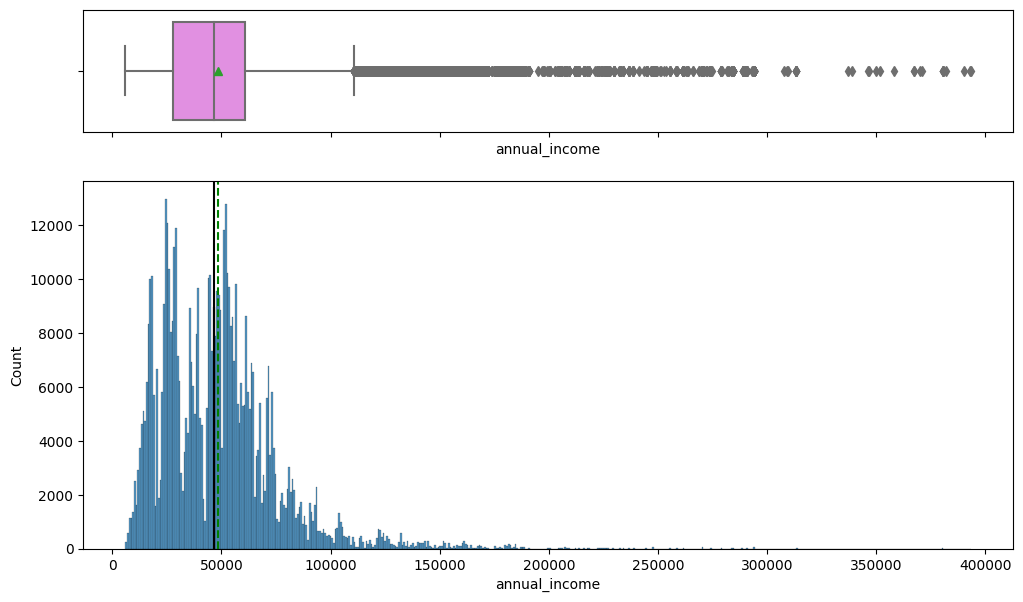

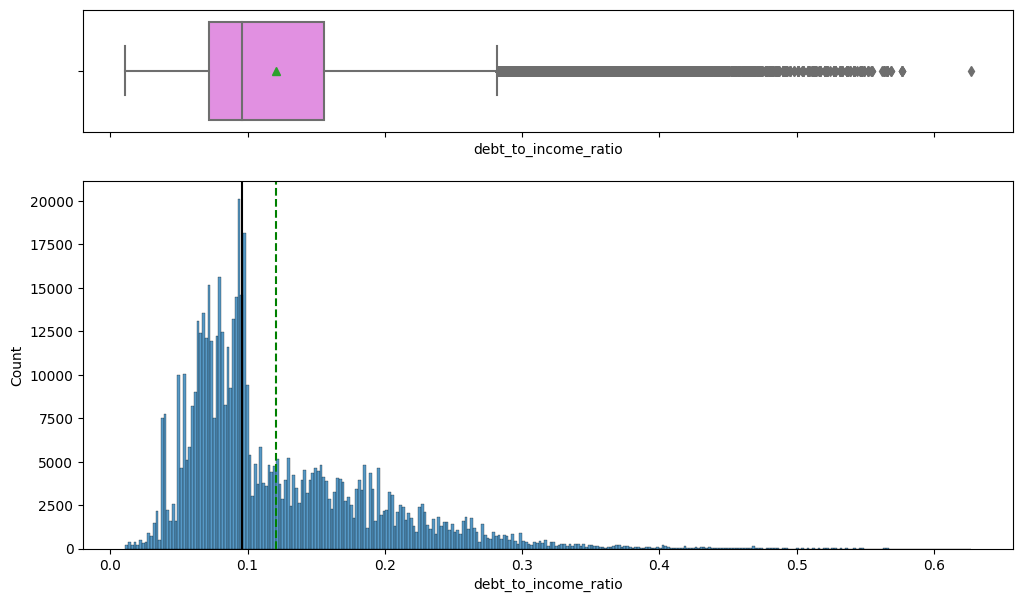

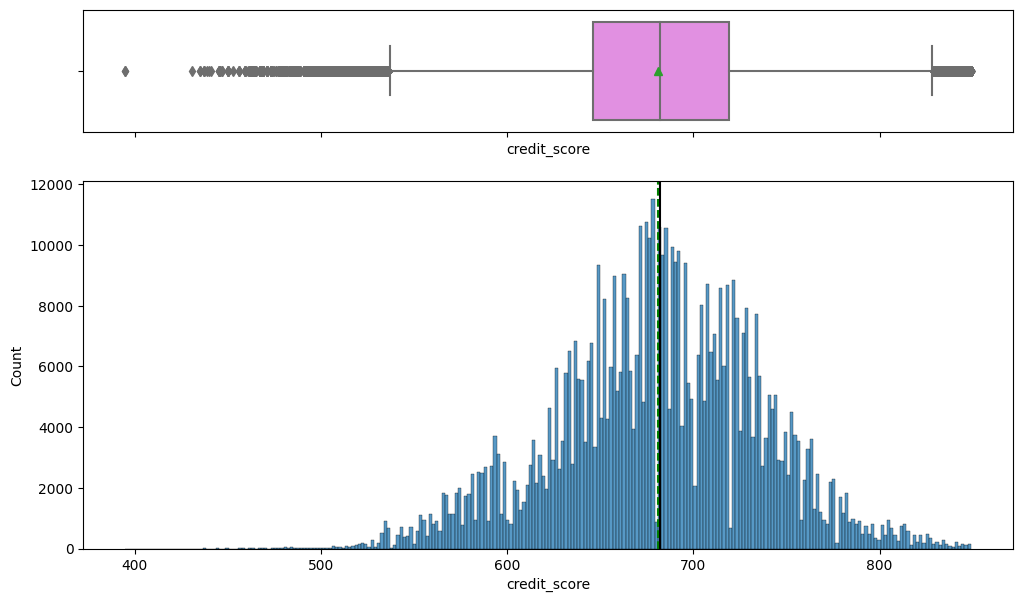

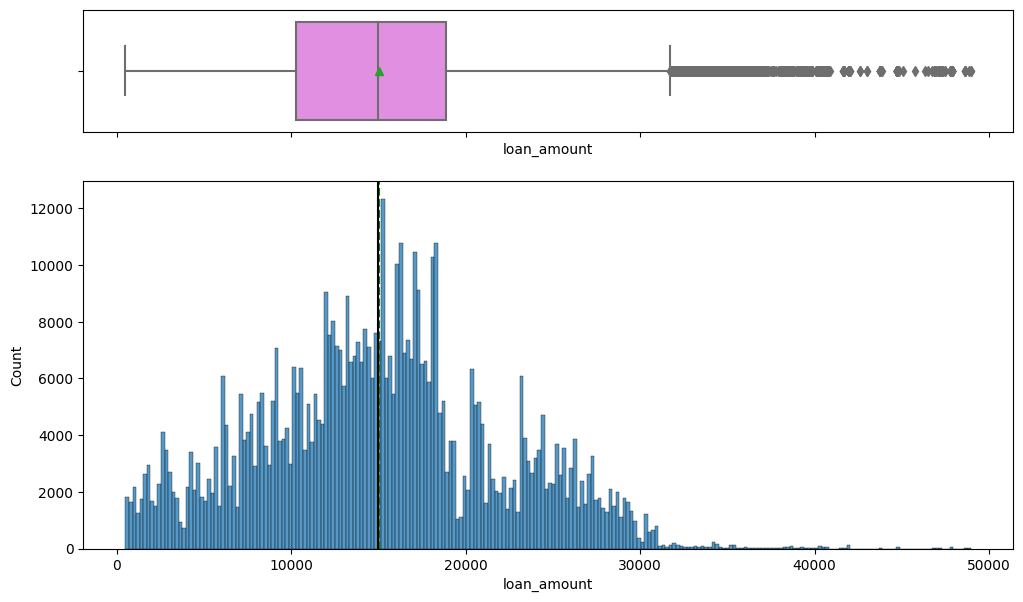

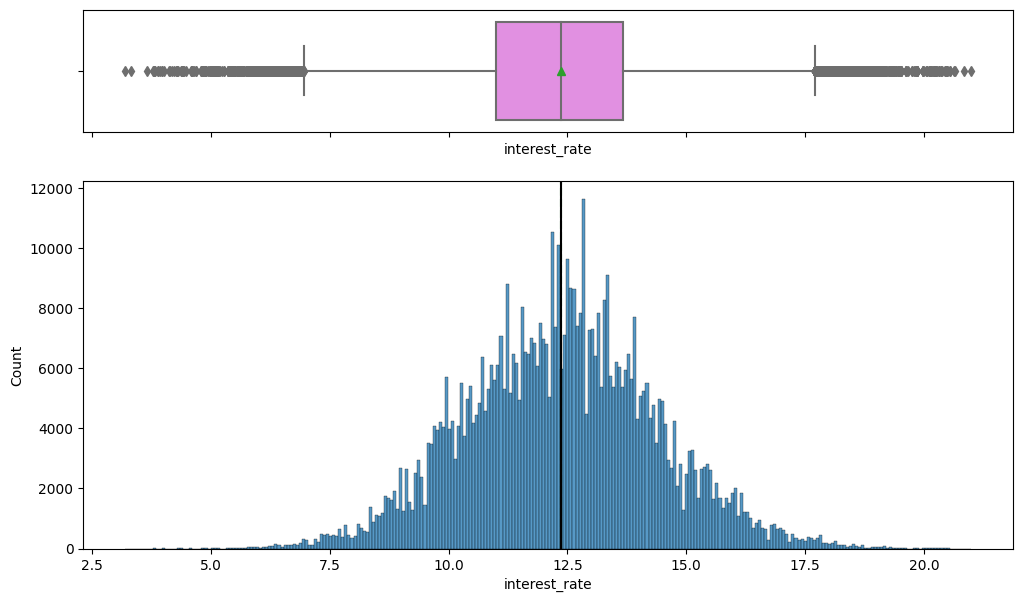

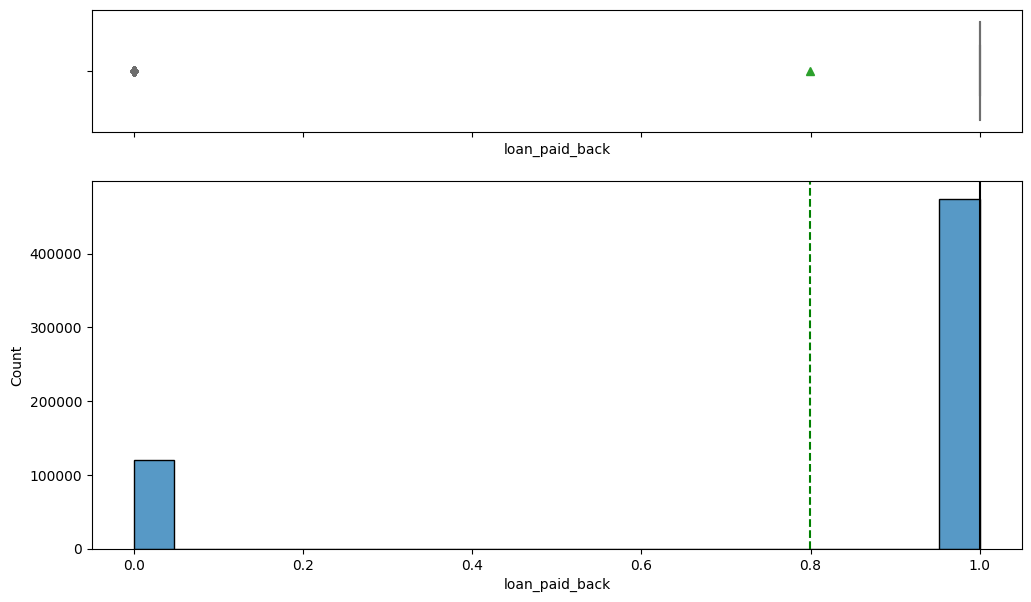

In [17]:
# Plot box plot and histogram for numerical data.
for feature in numerical_features:
    histogram_boxplot(data, feature)  
    

**Observation:**
1. Annual income is right-skewed and has outliers.
2. Debt-to-income ratio is right-skewed and has outliers.
3. Credit score has a near-normal distribution and has some outliers.
4. Loan amount exhibits a multimodal distribution and has outliers.
5. Interest rate is normally distributed and has outliers.
6. Loan paid back is categorical in nature, there is an imbalance between loan paid to unpaid customers in the data.

In [18]:
# Get Categorical features
categorical_features = data.select_dtypes(exclude="number").columns.to_list()
categorical_features

['gender',
 'marital_status',
 'education_level',
 'employment_status',
 'loan_purpose',
 'grade_subgrade']

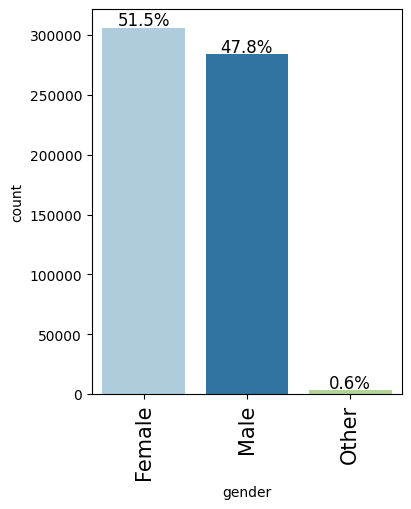

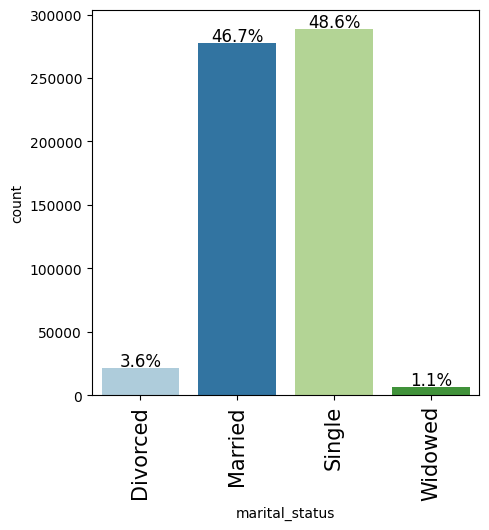

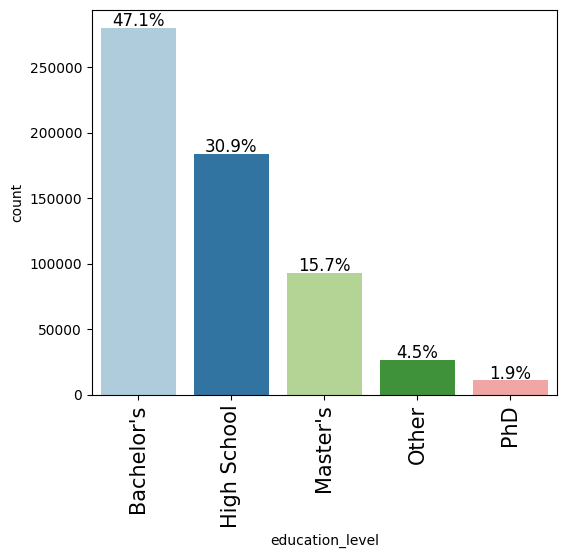

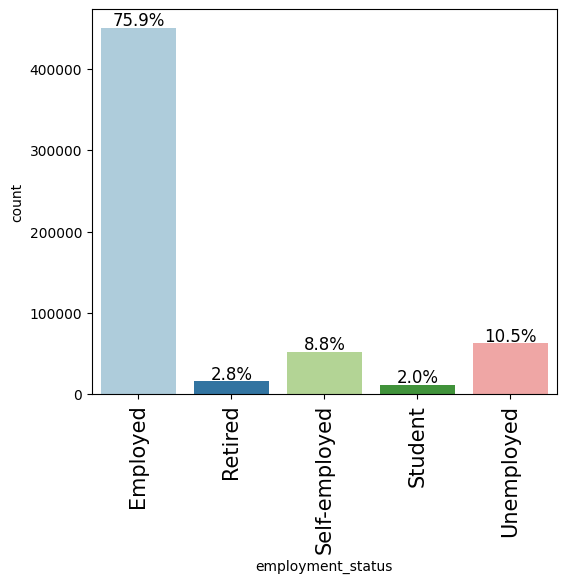

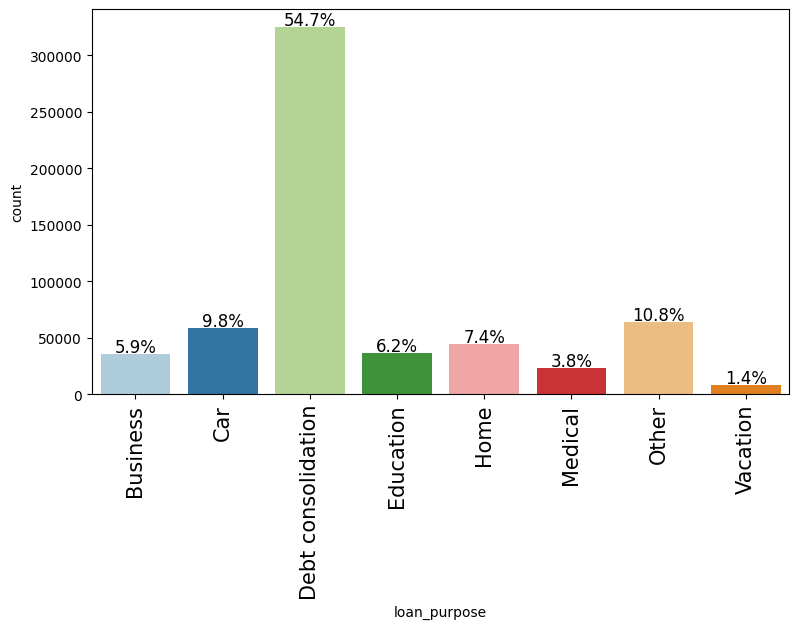

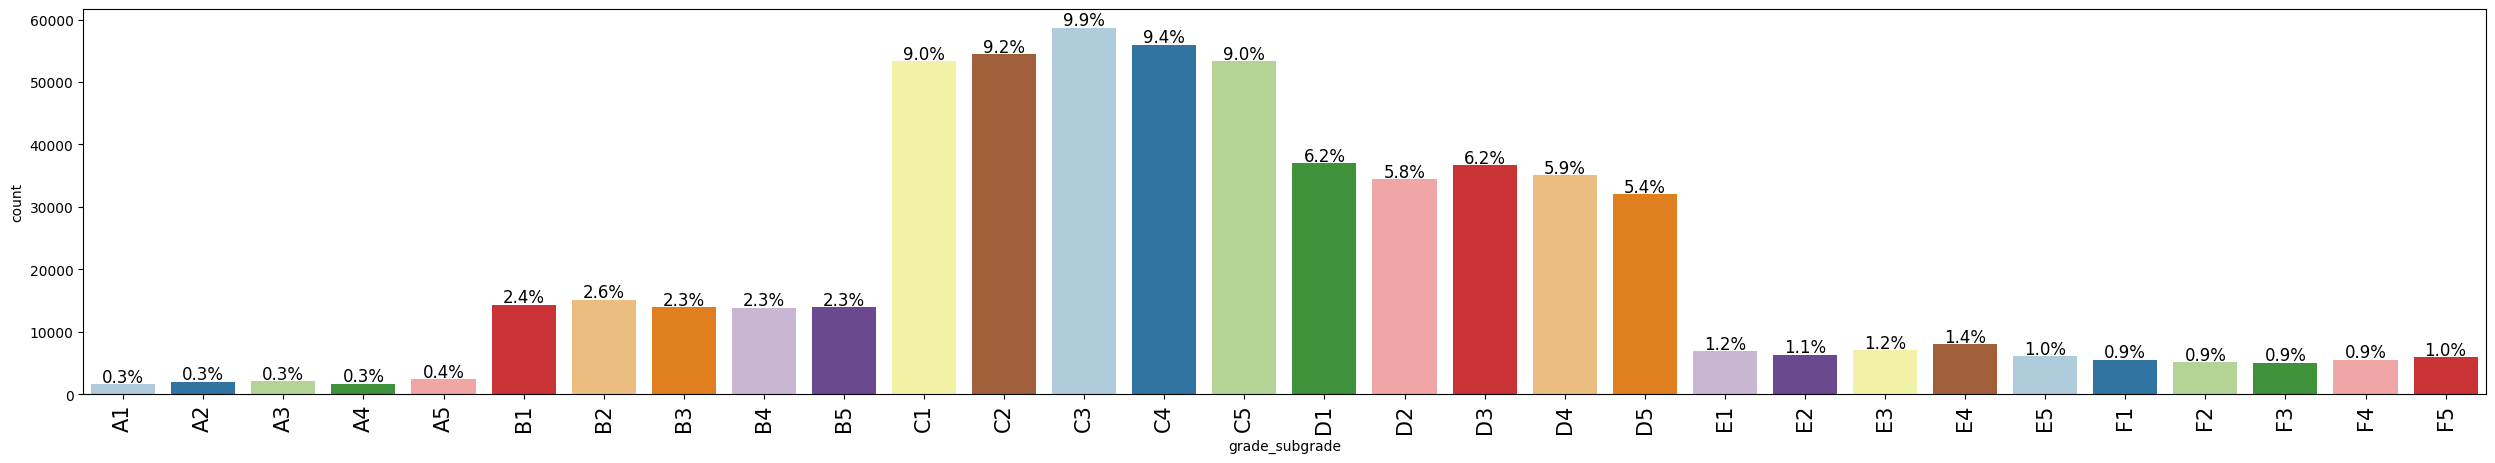

In [19]:
# Plot bar plots for categorical features.
for feature in categorical_features:
    labeled_barplot(data, feature, perc=True)
    

**Observation:**
1. Customers identify themselves as either Male, Female, or Other. Male and Female are the dominant gender types.
2. Marital status has four categories- Single, Married, Divorced, and Widowed
3. 95% of the customers have at least a high-school education.
4. 75% of the customers are employed, where as 10% of the customers are unemployed.
5. 55% of the loans are for debt consolidation.6. 

## Bivariate Analysis

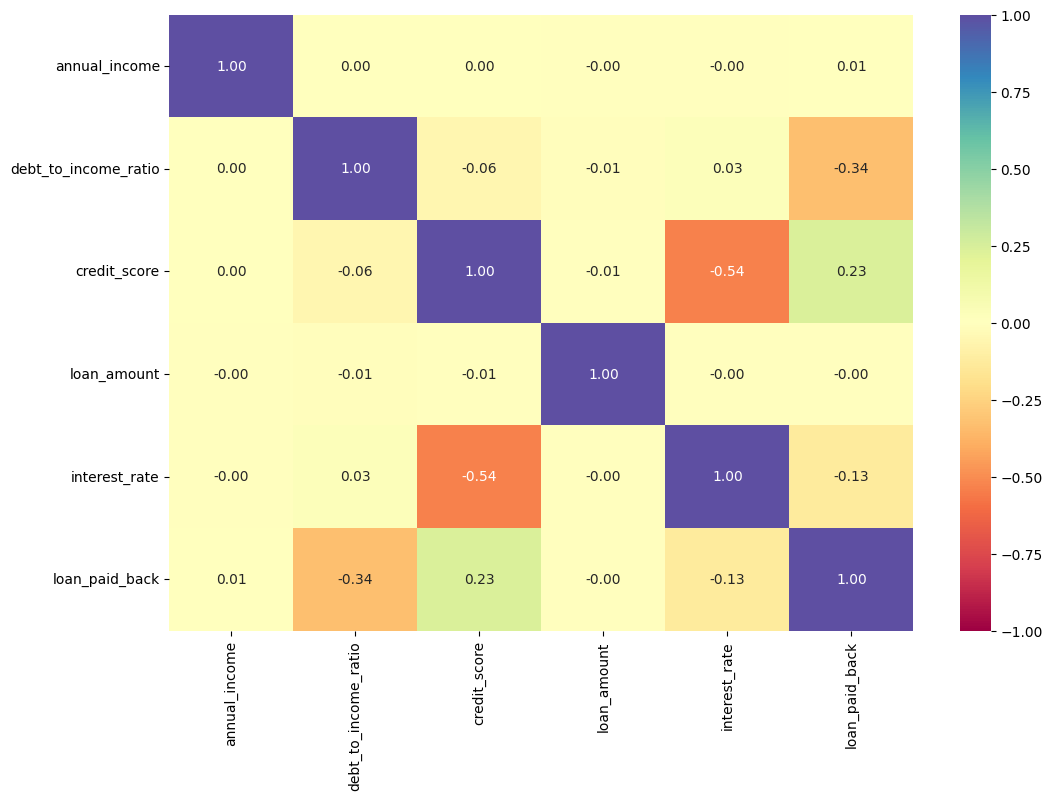

In [20]:
## Check correlation
plt.figure(figsize=(12,8))
sns.heatmap(data.corr(numeric_only=True),annot=True,vmin=-1,vmax=1,fmt='.2f',cmap="Spectral")
plt.show()


**Observation:**
1. Debt-to-income ratio has a negative correlation with Loan repayment, indicating customers with high debt are likely to not pay their loan.
2. Credit score has a negative correlation with interest rate, indicating that customers with higher credit scores have lower interest rates.
3. Credit score has a positive correlation with loan_paid_back, indicating customers with higher credit scores are likely to pay back their loans.

### Loan pay back vs Gender

loan_paid_back     0.0     1.0     All
gender                                
All             119500  474494  593994
Female           60712  245463  306175
Male             58025  226066  284091
Other              763    2965    3728
------------------------------------------------------------------------------------------------------------------------


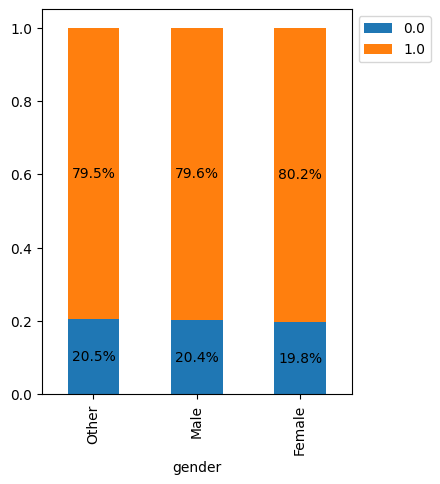

In [21]:
stacked_barplot(data, "gender", "loan_paid_back")

**Observation:**
* Loan payback distribution is very similar across genders; about 20% of customers do not pay the loan.


### Loan pay back vs Marital status

loan_paid_back     0.0     1.0     All
marital_status                        
All             119500  474494  593994
Single           58094  230749  288843
Married          55685  221554  277239
Divorced          4334   16978   21312
Widowed           1387    5213    6600
------------------------------------------------------------------------------------------------------------------------


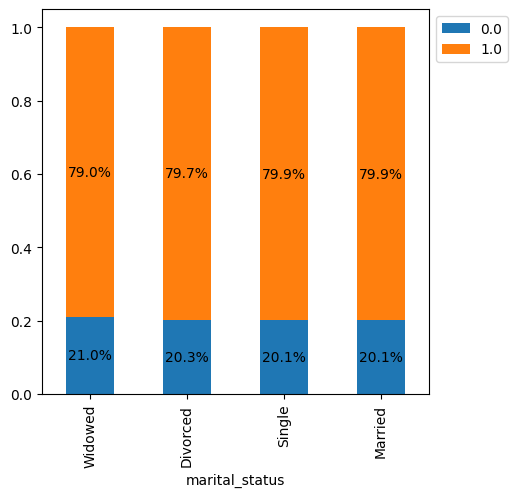

In [22]:
stacked_barplot(data, "marital_status", "loan_paid_back")

**Observation:**
* Loan payback distribution is very similar across the marital status of the customers; about 20% of customers do not pay the loan.

### Loan pay back vs education_level

loan_paid_back      0.0     1.0     All
education_level                        
All              119500  474494  593994
Bachelor's        59027  220579  279606
High School       34938  148654  183592
Master's          18401   74696   93097
Other              5261   21416   26677
PhD                1873    9149   11022
------------------------------------------------------------------------------------------------------------------------


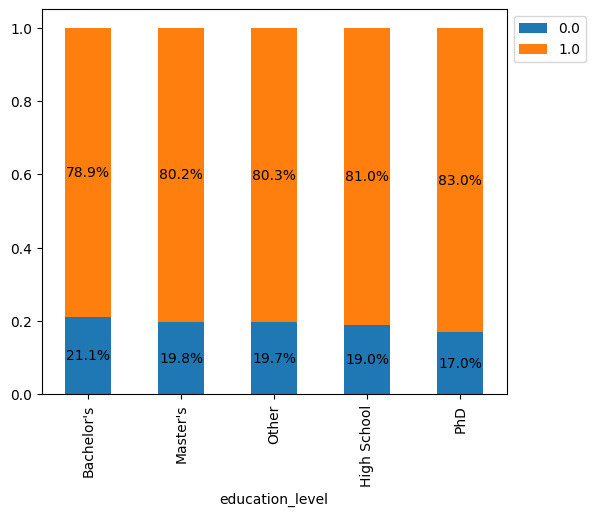

In [23]:
stacked_barplot(data, "education_level", "loan_paid_back")

**Observation:**
* Loan payback is higher among the PhD's and lowest in Bachelors.

### Loan pay back vs employment status

loan_paid_back        0.0     1.0     All
employment_status                        
All                119500  474494  593994
Unemployed          57635    4850   62485
Employed            47703  402942  450645
Student              8787    3144   11931
Self-employed        5329   47151   52480
Retired                46   16407   16453
------------------------------------------------------------------------------------------------------------------------


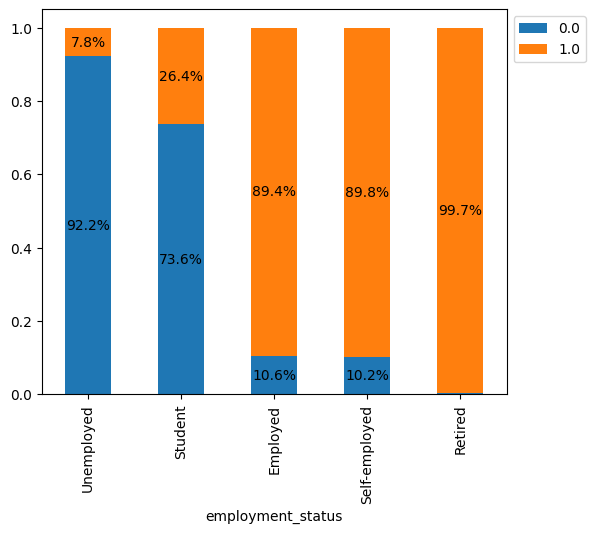

In [24]:
stacked_barplot(data, "employment_status", "loan_paid_back")

**Observation:**
1. Employment status is a significant factor in customers ability to pay the loan.
2. 92% of the unemployed and 74% of the students do not pay back the loan.
3. Retired customers pay back loans almost all the time.
4. 90% of the employed and self-employed customers pay the loan.

### Loan pay back vs loan purpose

loan_paid_back         0.0     1.0     All
loan_purpose                              
All                 119500  474494  593994
Debt consolidation   65942  258753  324695
Other                12623   51251   63874
Car                  11585   46523   58108
Education             8169   28472   36641
Home                  7799   36319   44118
Business              6598   28705   35303
Medical               5061   17745   22806
Vacation              1723    6726    8449
------------------------------------------------------------------------------------------------------------------------


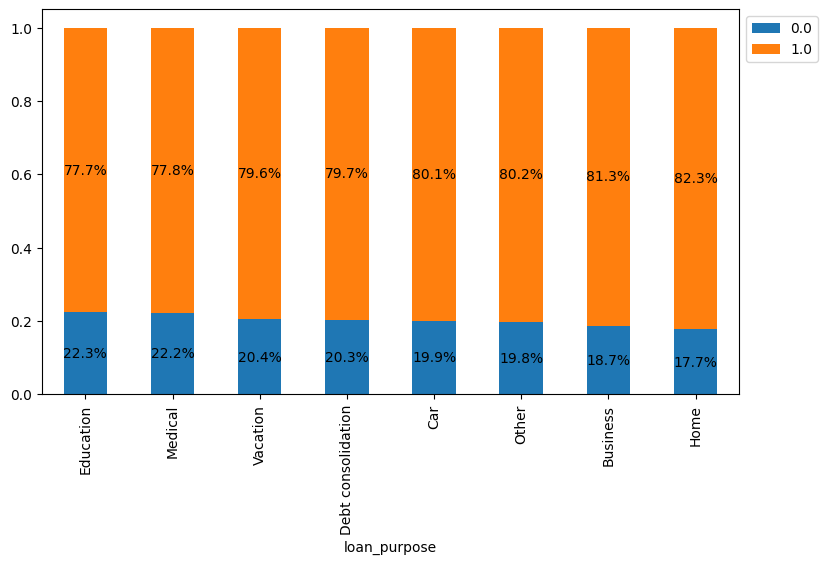

In [25]:
stacked_barplot(data, "loan_purpose", "loan_paid_back")

**Observation:**
1. 22% of Education and Medical loans are not paid back.
2. At least 80% of the Vacation, Debt consolidation, car, Business, Home and other loans are paid back.

### Loan pay back vs grade_subgrade

loan_paid_back     0.0     1.0     All
grade_subgrade                        
All             119500  474494  593994
D3               11156   25538   36694
D4               10012   25085   35097
D1                9928   27101   37029
C3                9626   49069   58695
D2                9608   24824   34432
D5                9213   22888   32101
C4                8730   47227   55957
C5                8197   45120   53317
C2                8103   46340   54443
C1                7466   45897   53363
E4                2816    5220    8036
E3                2534    4541    7075
E1                2398    4493    6891
E2                2149    4223    6372
F5                2145    3802    5947
F1                2078    3456    5534
F3                2012    3070    5082
E5                2011    4073    6084
F4                2009    3526    5535
F2                1989    3214    5203
B1                1200   13144   14344
B2                 949   14218   15167
B4                 947   

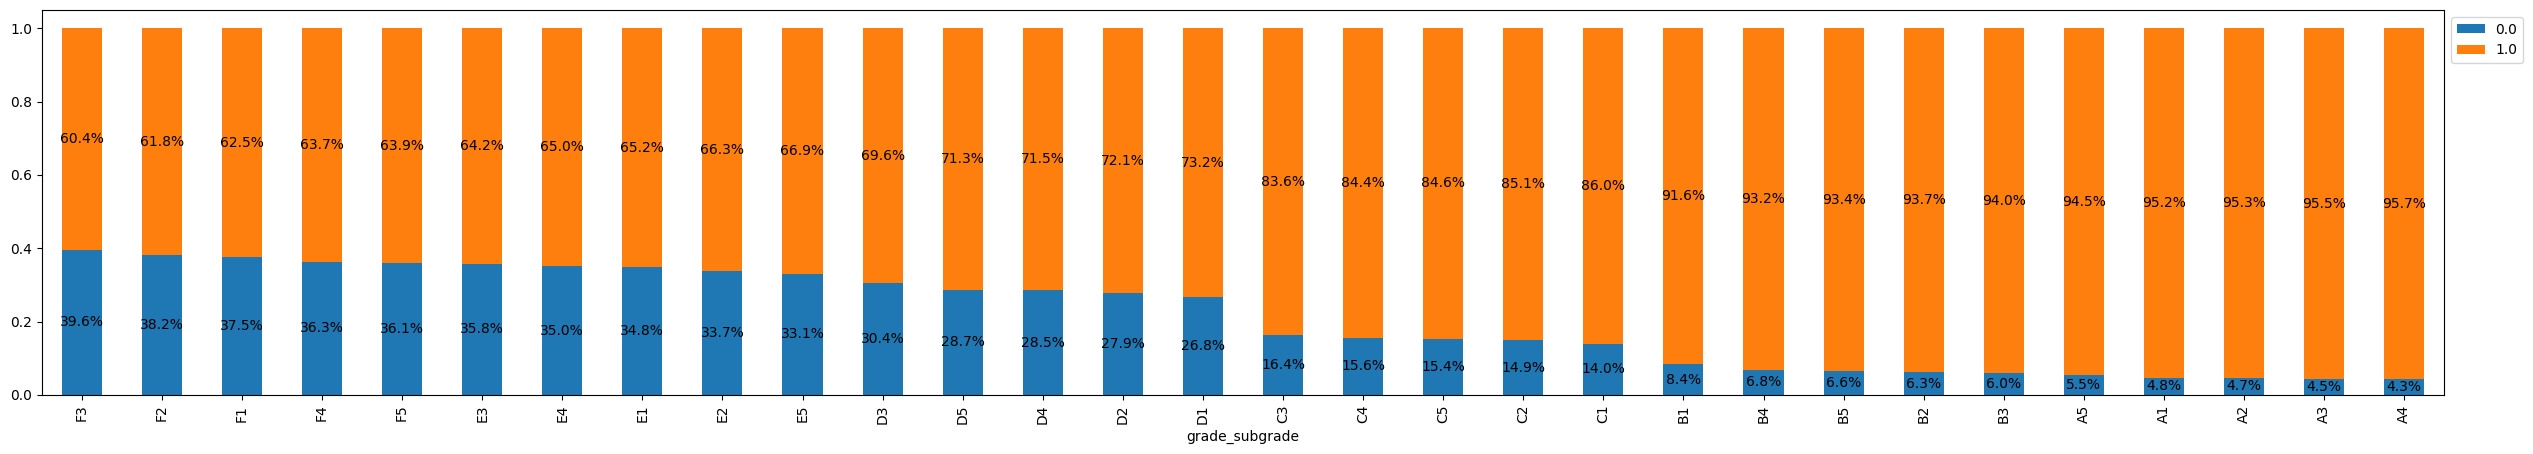

In [26]:
stacked_barplot(data, "grade_subgrade", "loan_paid_back")

**Observation:**
* It appears that as the loan grade increases (A to F), the payback decreases, indicating a negative correlation.

### Loan paid back vs annual income

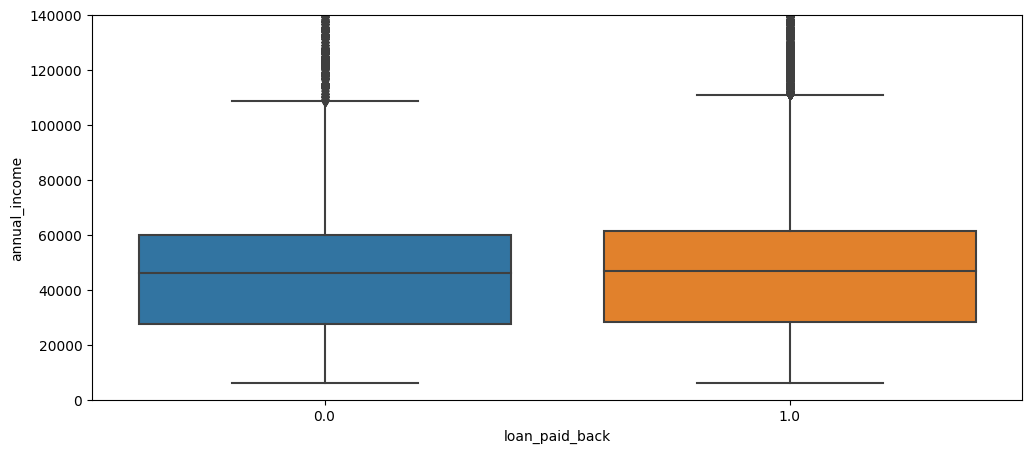

In [27]:
plt.figure(figsize=(12,5))
sns.boxplot(data=data, x='loan_paid_back', y='annual_income')
plt.ylim(0, 140000) # Set a new upper limit, for example, 150000
plt.show()

**Observation:** 
* Annual income shows a highly similar statistical distribution for both fully paid and defaulted loans, suggesting it might not be a strong differentiating factor on its own.
* Although it shows a similar distribution, the boxplot is probably not showing the underlying insights and needs further analysis.



In [28]:
# To define custom bin edges (e.g., $0-50k, $50k-100k, etc.)
#bins = [0, 10000,25000, 50000, 75000,100000, 150000, 200000, 250000, 300000, np.inf] # Use np.inf for the last upper bound
#labels = ['0-10k','10k-25K','25K-50k', '50k-75k','75k-100k', '100k-150k', '150k-200k', '200k - 250K','250k - 300K', '300K+']
#data['income_bin_custom'] = pd.cut(data['annual_income'], bins=bins, labels=labels)

#data = income_bin(data)
#stacked_barplot(data, "income_bin_custom", "loan_paid_back")

**Observation:** 
* On average, loan default is around 20% or higher among all income ranges.
* The loan default among the customers with 200K+ is higher.


### Loan paid back vs debt to income ratio

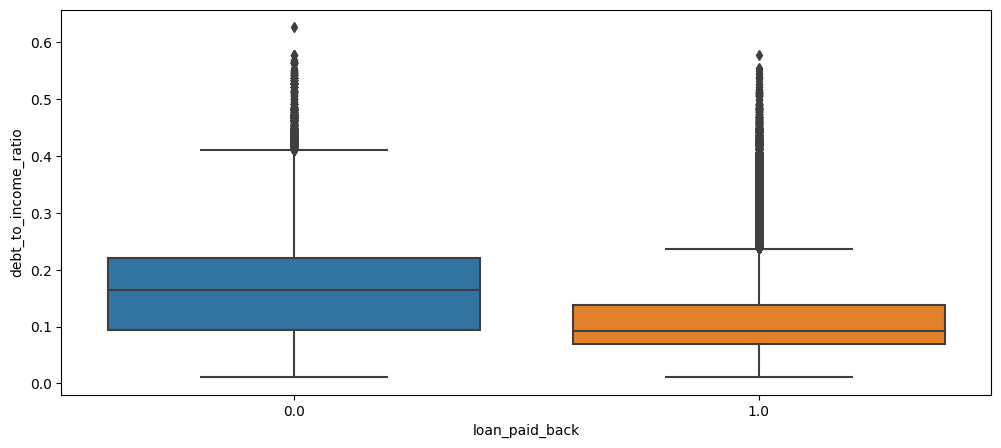

In [29]:
plt.figure(figsize=(12,5))
sns.boxplot(data=data, x='loan_paid_back', y='debt_to_income_ratio')
plt.show()

**Observation:** Customers with a higher debt-to-income (DTI) ratio exhibit a higher probability of loan default, indicating that the DTI ratio is a significant predictive feature.

### Loan paid back vs Credit score

<Axes: xlabel='loan_paid_back', ylabel='credit_score'>

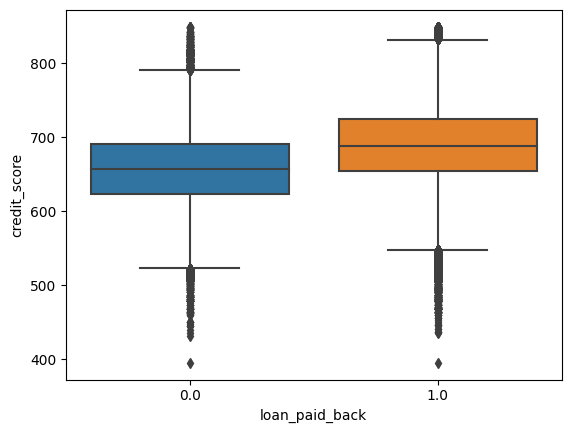

In [30]:
sns.boxplot(data=data, x='loan_paid_back', y='credit_score')

**Observation:** A significant majority (75%) of customers who successfully repaid their loans have credit scores of 650 or higher.

## Data Preperation for model building.

In [31]:
#X = data.drop(['loan_paid_back', 'annual_income'],axis=1)
#y = data['loan_paid_back']


X = data.drop(['loan_paid_back'],axis=1)
y = data['loan_paid_back']

categorical_features = data.select_dtypes(exclude='number').columns.to_list()
# change data type of categorical features from object to category
X[categorical_features] = X[categorical_features].astype('category')


#X = pd.get_dummies(X,drop_first=True,dtype=int)

In [32]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593994 entries, 0 to 593993
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   annual_income         593994 non-null  float64 
 1   debt_to_income_ratio  593994 non-null  float64 
 2   credit_score          593994 non-null  int64   
 3   loan_amount           593994 non-null  float64 
 4   interest_rate         593994 non-null  float64 
 5   gender                593994 non-null  category
 6   marital_status        593994 non-null  category
 7   education_level       593994 non-null  category
 8   employment_status     593994 non-null  category
 9   loan_purpose          593994 non-null  category
 10  grade_subgrade        593994 non-null  category
dtypes: category(6), float64(4), int64(1)
memory usage: 26.1 MB


In [33]:
# Check the distribution of classes.
round(y.value_counts(normalize=True)*100,3)

loan_paid_back
1.0    79.882
0.0    20.118
Name: proportion, dtype: float64

**Observation:** Target classes are imbalanced in the training data, which should be accounted in the modeling.

## Model building - Simple XGBoost

In [34]:
# split the data for training and testing.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y) 

weights = compute_sample_weight(class_weight='balanced', y=y_train)

# model definition.
xgb = XGBClassifier(random_state=42, eval_metric='auc', enable_categorical=True)

# Fit the training data
xgb.fit(X_train,y_train,sample_weight=weights)

# Make predictions
y_test_prob = xgb.predict_proba(X_test)[:,1]

# Model evaluation
# Calculate the roc_auc_score of the predictions
roc_auc = roc_auc_score(y_test, y_test_prob)
print(f"roc_auc_score: {roc_auc:.4f}")


roc_auc_score: 0.9190


## Fine-tune the hyperparameters

In [35]:
# No. of splits
n_splits = 5

# Stratified KFlod
skf = StratifiedKFold(n_splits=n_splits,random_state=42, shuffle=True)


In [36]:
# Prepare X_test from test data
X_test = test_data.drop(['id'],axis=1)
#X_test = income_bin(X_test)
#X_test = X_test.drop('annual_income', axis=1)

# change data type of categorical features from object to category
X_test[categorical_features] = X_test[categorical_features].astype('category')
#X_test = pd.get_dummies(X,drop_first=True,dtype=int)
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 254569 entries, 0 to 254568
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   annual_income         254569 non-null  float64 
 1   debt_to_income_ratio  254569 non-null  float64 
 2   credit_score          254569 non-null  int64   
 3   loan_amount           254569 non-null  float64 
 4   interest_rate         254569 non-null  float64 
 5   gender                254569 non-null  category
 6   marital_status        254569 non-null  category
 7   education_level       254569 non-null  category
 8   employment_status     254569 non-null  category
 9   loan_purpose          254569 non-null  category
 10  grade_subgrade        254569 non-null  category
dtypes: category(6), float64(4), int64(1)
memory usage: 11.2 MB


In [37]:
# Hyper parameters
params = {
    'objective': "binary:logistic",
    'n_estimators': 5000,
    'learning_rate':'0.04',
    'eval_metric':'auc',
    'max_depth':5,
    'colsample_bytree':0.6,
    'subsample':0.8,
    'random_state':42,
    'n_jobs':-1,
    'use_label_encoder':False,
    'early_stopping_rounds': 100,
    'enable_categorical':True,
    #'scale_pos_weight':weights
    #'reg_alpha':0.1,
    #'reg_lambda':0.5
    'gamma': 3.02,
    'min_child_weight':12 
    
}



In [38]:
# Lists to store the evaluation scores from each fold
auc_scores = []
test_preds = np.zeros(len(X_test))
val_preds = np.zeros(len(X))

# Loop through each fold generated by StratifiedKFold
for fold, (train_index, val_index) in enumerate(skf.split(X,y)):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    weights_train = compute_sample_weight(class_weight='balanced', y=y_train)

    print(f"-------Fold:{fold}, Splits:{n_splits}-----")

    xgb_tuned = XGBClassifier(
        **params, 
        verbose=1000)
    
    # Fit the model on training data.
    xgb_tuned.fit(
        X_train, 
        y_train, 
        eval_set=[(X_val, y_val)],
        sample_weight=weights_train,
        verbose=1000
    )

    # Predict probability on validation data set.
    y_val_prob = xgb_tuned.predict_proba(X_val)[:,1]
    val_preds[val_index] = y_val_prob


    # Calculate auc score
    fold_auc = roc_auc_score(y_val, y_val_prob)
    print(f"Fold {fold} - Validation auc score:{fold_auc}")

    # Predict probability on test data set.
    y_test_prob = xgb_tuned.predict_proba(X_test)[:,1]
    test_preds += y_test_prob / (n_splits) 

overall_auc = roc_auc_score(y, val_preds)
print('Overall VAL AUC: {}'.format(overall_auc))
print('-'*50)    

results = pd.DataFrame({"id": test_data.id, "loan_paid_back": test_preds})
results.to_csv('submission.csv', index=False)



-------Fold:0, Splits:5-----
[0]	validation_0-auc:0.78172
[1000]	validation_0-auc:0.92250
[1347]	validation_0-auc:0.92272
Fold 0 - Validation auc score:0.9227370497530937
-------Fold:1, Splits:5-----
[0]	validation_0-auc:0.78065
[1000]	validation_0-auc:0.92198
[1769]	validation_0-auc:0.92226
Fold 1 - Validation auc score:0.9222819065378515
-------Fold:2, Splits:5-----
[0]	validation_0-auc:0.77877
[1000]	validation_0-auc:0.92036
[1282]	validation_0-auc:0.92054
Fold 2 - Validation auc score:0.9205557901880358
-------Fold:3, Splits:5-----
[0]	validation_0-auc:0.77804
[1000]	validation_0-auc:0.92127
[1560]	validation_0-auc:0.92146
Fold 3 - Validation auc score:0.9214798223488957
-------Fold:4, Splits:5-----
[0]	validation_0-auc:0.77967
[1000]	validation_0-auc:0.92087
[1617]	validation_0-auc:0.92108
Fold 4 - Validation auc score:0.9210807640107932
Overall VAL AUC: 0.9216222645138666
--------------------------------------------------
